In [2]:
#Loads some parameters
import CloudDataset128h
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
import torchvision.transforms.v2 as v2
from PIL import Image
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu
import torch.optim as optim
batch_size = 7

#imports state of the art model.
#model = torch.hub.load('pytorch/vision:v0.10.0', 'fcn_resnet50')
print("Load successfull")


Load successfull


<class 'torch.Tensor'>
torch.Size([7, 12, 128, 128])
torch.Size([7, 6, 128, 128])


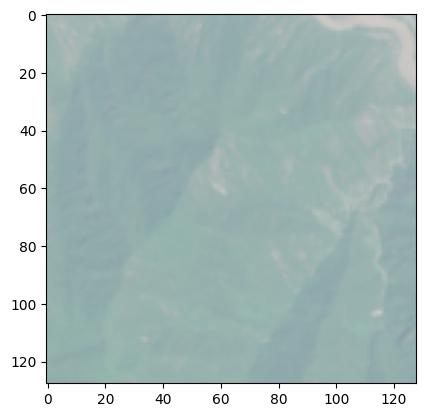

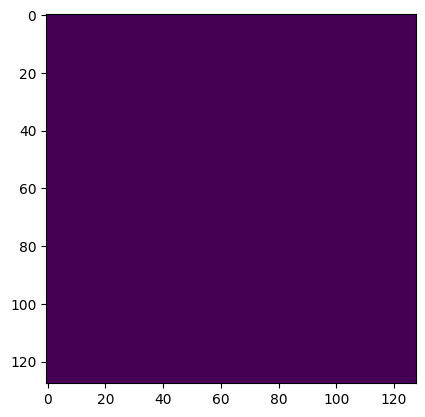

In [3]:
transform = {
    "image": v2.Compose([
    transforms.Resize(size=(256,256)),
]),
    "mask": v2.Compose([
    transforms.Resize(size=(256,256)),
])}

# Get the dataset of the CloudDataset
dataset = CloudDataset128h.CloudDataset("data\\train",transform=transform)

# Creates validation/training dataset with 20/80 split
validation_dataset, training_dataset = torch.utils.data.random_split(dataset,[0.2, 0.8])

# Create a DataLoaders from the datasets.
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=batch_size, shuffle=True)
training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=batch_size, shuffle=True)

# Creates an iterator and plots the pictures
it = iter(training_loader)
images, labels = next(it)

print(type(images))
print(images.shape)
print(labels.shape)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=4
plt.imshow(labels[0][i:i+1].permute(1,2,0))
plt.show()

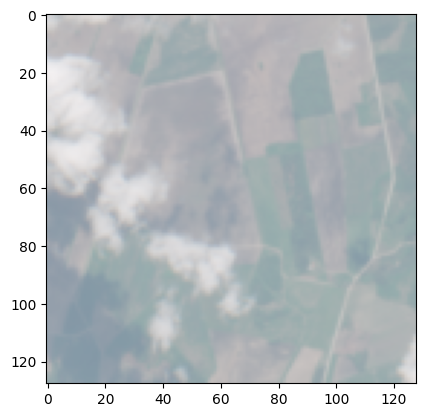

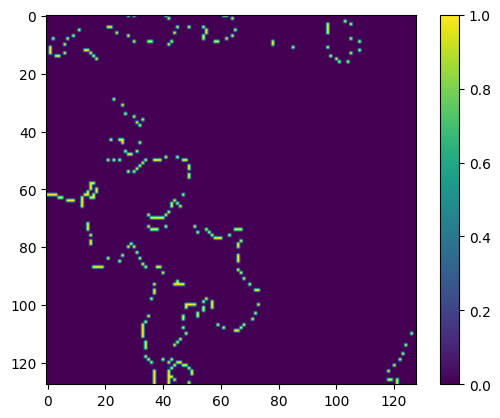

In [4]:
# Grabs next bath of pictures and displays the first, run multiple times for different plots
images, labels = next(it)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

plt.figure()
i=3
img = plt.imshow(labels[0][i:i+1].permute(1,2,0),vmin=0,vmax=1)
plt.colorbar(img)
plt.show()

In [5]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image. 
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 128x128x12
        self.e11 = nn.Conv2d(12, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 64x64x64

        # input: 64x64x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x128

        # input: 32x32x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 16x16x256

        # input: 16x16x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 8x8x512

        # input: 8x8x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 4x4x1024

        # input: 4x4x1024
        self.e61 = nn.Conv2d(1024, 2048, kernel_size=3, padding=1) # output: 4x4x2048
        self.e62 = nn.Conv2d(2048, 2048, kernel_size=3, padding=1) # output: 4x4x2048


        # Decoder
        # input: 4x4x2048
        self.upconv0 = nn.ConvTranspose2d(2048, 1024, kernel_size=2, stride=2) # output: 8x8x2048
        self.d01 = nn.Conv2d(2048, 1024, kernel_size=3, padding=1) # output: 8x8x1024
        self.d02 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 8x8x1024


        # input: 8x8x1024
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2) # output: 16x16x1024
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1) # output: 16x16x512
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 16x16x512

        # input: 16x16x512
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2) # output: 32x32x512
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1) # output: 32x32x256
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 32x32x256

        # input: 32x32x256
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2) # output: 64x64x256
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1) # output: 64x64x128
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 64x64x128

        # input: 64x64x128
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2) # output: 128x128x128
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1) # output: 128x128x64
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 128x128x64

        # Output layer
        # input: 128x128x64
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1) # output: 128 x 128 x n_class

        #Dropout
        self.dropout = nn.Dropout(0.85)
    
    def forward(self, x):
        # Encoder
        #print(x.shape)
        xe11 = relu(self.e11(x))
        #print(xe11.shape)
        xe12 = relu(self.e12(xe11))
        #print(xe12.shape)
        xp1 = self.pool1(xe12)
        #print(xp1.shape)

        xe21 = relu(self.e21(xp1))
        #print(xe21.shape)
        xe22 = relu(self.e22(xe21))
        #print(xe22.shape)
        xp2 = self.pool2(xe22)
        #print(xp2.shape)

        xe31 = relu(self.e31(xp2))
        #print(xe31.shape)
        xe32 = relu(self.e32(xe31))
        #print(xe32.shape)
        xp3 = self.pool3(xe32)
        #print(xp3.shape)

        xe41 = relu(self.e41(xp3))
        #print(xe41.shape)
        xe42 = relu(self.e42(xe41))
        #print(xe42.shape)
        xp4 = self.pool4(xe42)
        #print(xp4.shape)

        xe51 = relu(self.e51(xp4))
        #print(xe51.shape)
        xe52 = relu(self.e52(xe51))
        #print(xe52.shape)
        xp5 = self.pool5(xe52)
        #print(xp5.shape)

        xe61 = relu(self.e61(xp5))
        #print(xe51.shape)
        xe62 = relu(self.e62(xe61))
        #print(xe52.shape)
        
        # Decoder
        xu0 = self.upconv0(xe62)
        xu01 = torch.cat([xu0, xe52], dim=1)
        xd01 = relu(self.d01(xu01))
        xd02 = relu(self.d02(xd01))

        xu1 = self.upconv1(xd02)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.d11(xu11))
        xd12 = relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.d21(xu22))
        xd22 = relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.d31(xu33))
        xd32 = relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.d41(xu44))
        xd42 = relu(self.d42(xd41))

        # Output layer
        out=self.outconv(xd42)

        return out

Epoch: 0 batch_nr: 0 Time: 3.685574800008908 Time_diff: 3.6855760000180453 loss: 2.114274740219116
Epoch: 0 batch_nr: 8 Time: 72.4639496000018 Time_diff: 7.924820899963379 loss: 2.4297663503222995

 New best loss: 2.8536922136942544


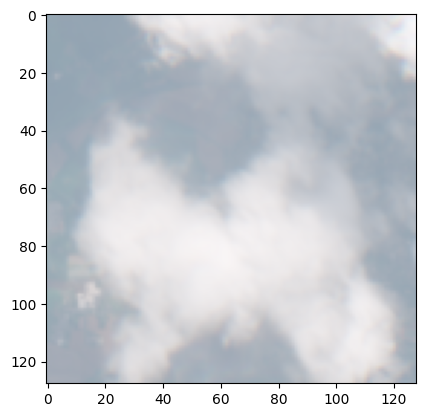

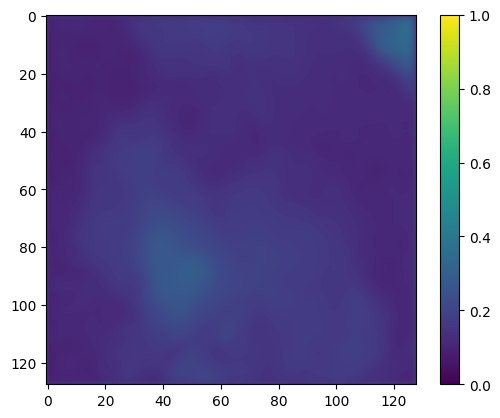

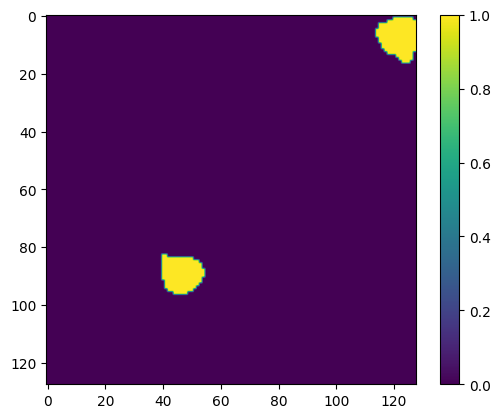

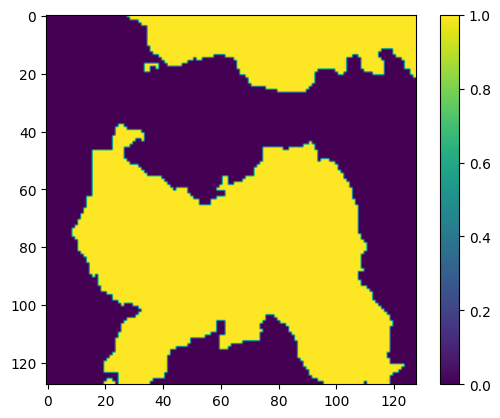

Epoch: 1 batch_nr: 7 Time: 166.5335977000068 Time_diff: 7.99669180001365 loss: 2.6654097139835358
new val loss: 3.0142213503519693
Epoch: 2 batch_nr: 6 Time: 250.7933240000275 Time_diff: 8.066554900025949 loss: 1.9048396008355277

 New best loss: 2.637535254160563


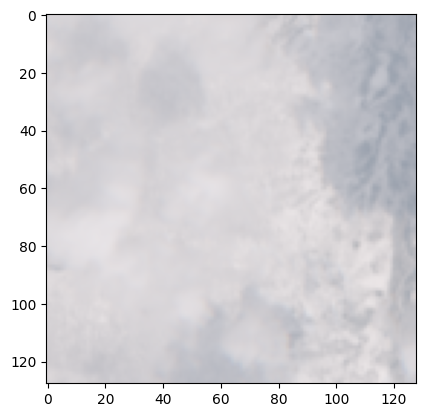

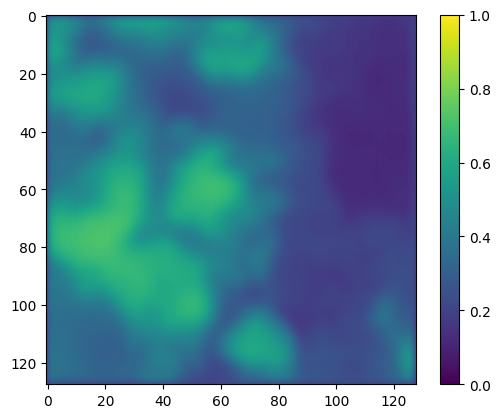

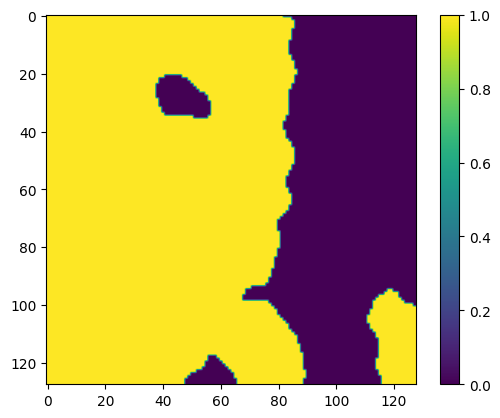

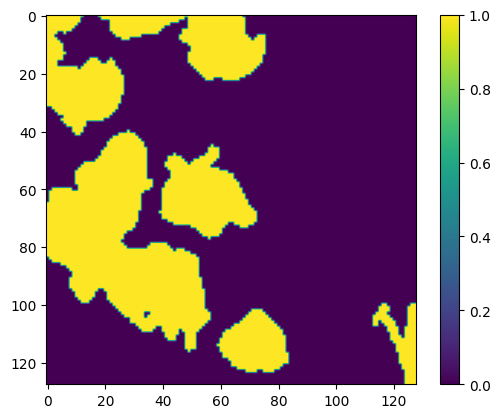

Epoch: 3 batch_nr: 5 Time: 338.6173644000082 Time_diff: 7.979153599997517 loss: 3.105372965335846

 New best loss: 2.5316207011540732


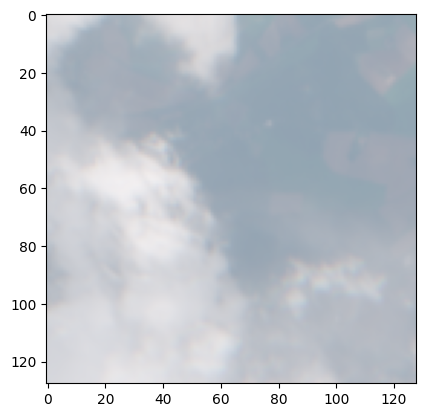

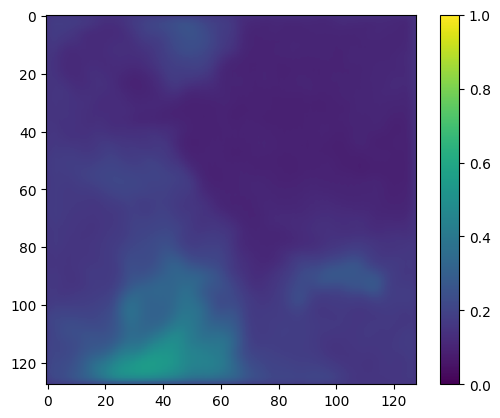

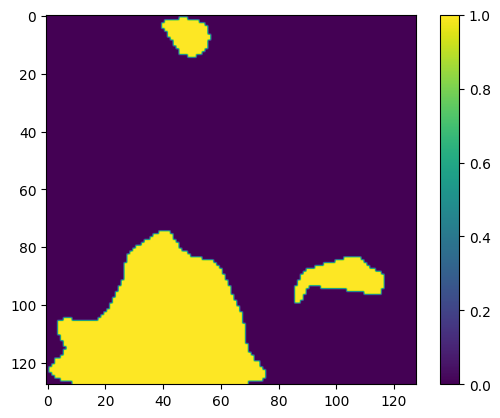

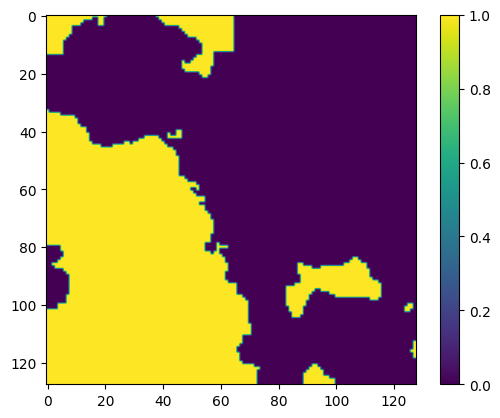

Epoch: 4 batch_nr: 4 Time: 429.8115407000296 Time_diff: 8.043854900053702 loss: 3.804445266723633
new val loss: 3.112903674443563
Epoch: 5 batch_nr: 3 Time: 514.9877688999986 Time_diff: 8.076622999971732 loss: 2.483453720808029
new val loss: 2.667661190032959
Epoch: 6 batch_nr: 2 Time: 599.1954061000142 Time_diff: 7.664593699970283 loss: 2.4540023803710938
Epoch: 6 batch_nr: 10 Time: 662.6611986000207 Time_diff: 5.8582673000055365 loss: 2.268284862691706
new val loss: 2.6816960175832114
Epoch: 7 batch_nr: 1 Time: 690.5786298000021 Time_diff: 9.670881900005043 loss: 2.1174808144569397
Epoch: 7 batch_nr: 9 Time: 755.6971207000315 Time_diff: 7.953477000002749 loss: 2.5490473389625548

 New best loss: 2.4195671876271567


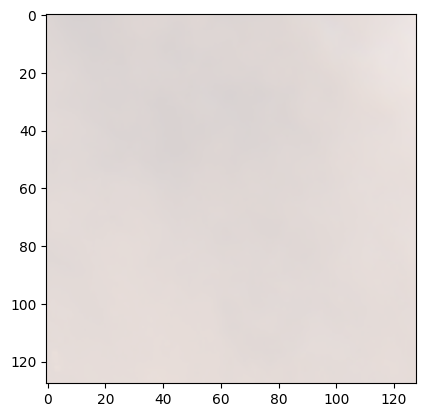

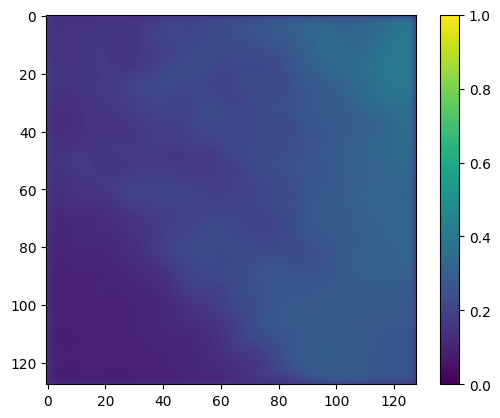

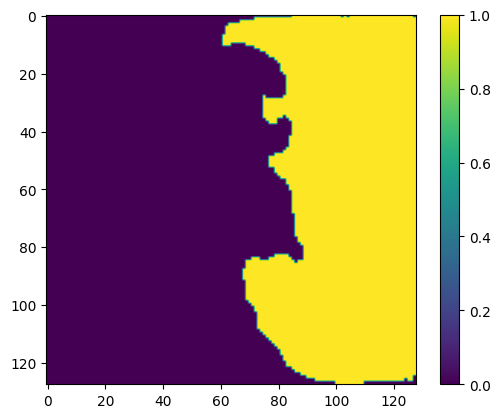

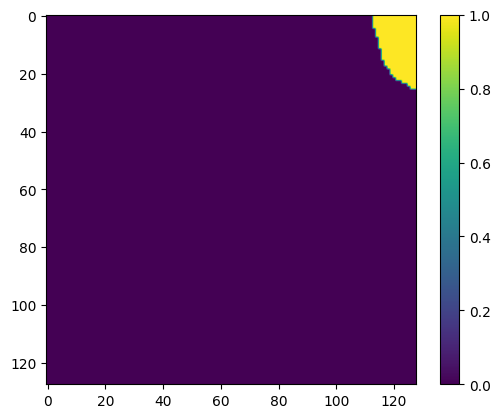

Epoch: 8 batch_nr: 0 Time: 782.589976200019 Time_diff: 21.910009099985473 loss: 39.114776611328125
Epoch: 8 batch_nr: 8 Time: 847.9929077000124 Time_diff: 8.024191899981815 loss: 6.033600409825643
new val loss: 2.9987478256225586
Epoch: 9 batch_nr: 7 Time: 934.5876798999961 Time_diff: 8.119848200003617 loss: 2.3017053604125977

 New best loss: 2.4173009395599365


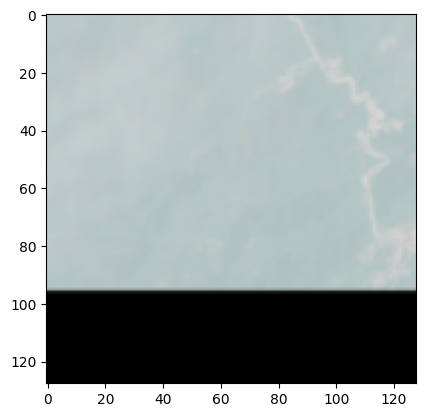

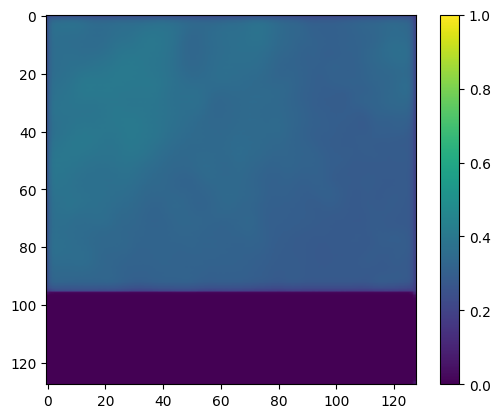

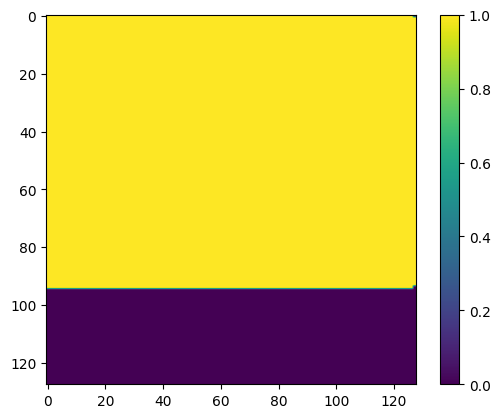

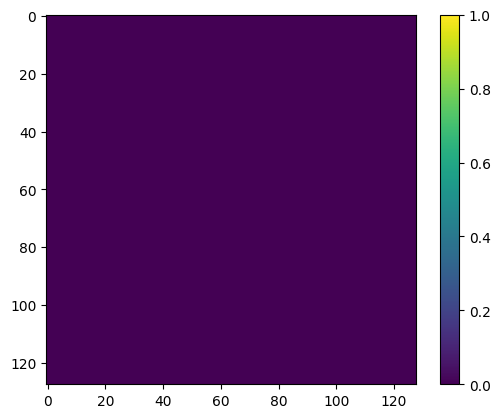

Epoch: 10 batch_nr: 6 Time: 1031.7181518000434 Time_diff: 8.428700100048445 loss: 2.1263686077935353
new val loss: 2.5265912612279258
Epoch: 11 batch_nr: 5 Time: 1119.049744500022 Time_diff: 9.082719600002747 loss: 2.623586336771647
new val loss: 2.8658181031545005
Epoch: 12 batch_nr: 4 Time: 1205.908217100019 Time_diff: 8.149059600022156 loss: 2.157521939277649
new val loss: 2.5073562463124595
Epoch: 13 batch_nr: 3 Time: 1292.180682700011 Time_diff: 8.432436099974439 loss: 1.8294423520565033

 New best loss: 2.3723394870758057


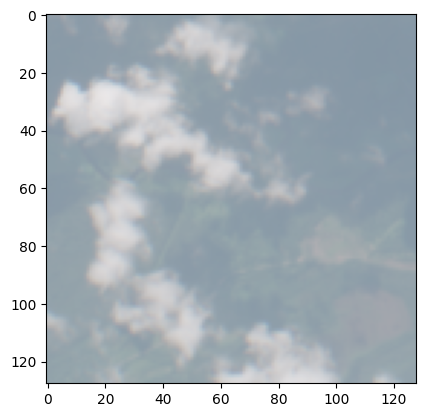

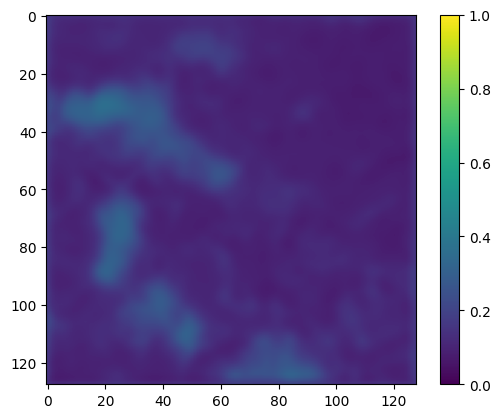

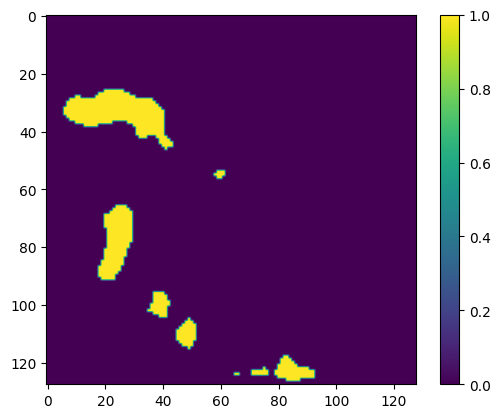

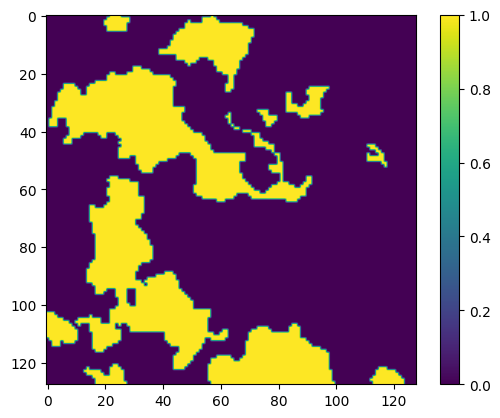

Epoch: 14 batch_nr: 2 Time: 1385.8437487000483 Time_diff: 10.96830869995756 loss: 1.6567436854044597
Epoch: 14 batch_nr: 10 Time: 1450.130650600011 Time_diff: 5.186080300016329 loss: 2.5200556191531094
new val loss: 2.5260398387908936
Epoch: 15 batch_nr: 1 Time: 1474.7901191000128 Time_diff: 8.093522200011648 loss: 2.65578031539917
Epoch: 15 batch_nr: 9 Time: 1540.2466058999998 Time_diff: 8.146571099990979 loss: 2.1440005779266356
new val loss: 2.652993599573771
Epoch: 16 batch_nr: 0 Time: 1561.0799701000215 Time_diff: 15.525411200011149 loss: 1.795037031173706
Epoch: 16 batch_nr: 8 Time: 1625.4984443000285 Time_diff: 8.028568300011102 loss: 4.039693686697218
new val loss: 2.5154402256011963
Epoch: 17 batch_nr: 7 Time: 1711.400844000047 Time_diff: 8.13364289997844 loss: 2.189001053571701
new val loss: 2.6804176966349282
Epoch: 18 batch_nr: 6 Time: 1796.6600762000307 Time_diff: 7.864988600020297 loss: 4.8348259925842285
new val loss: 2.516260782877604
Epoch: 19 batch_nr: 5 Time: 1882.99

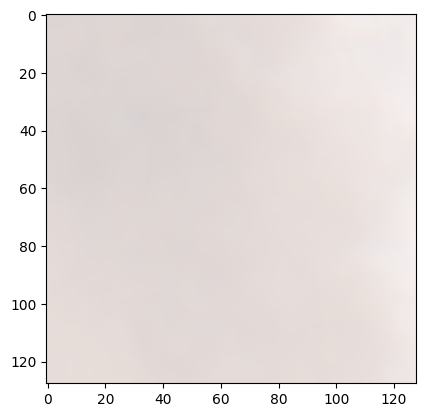

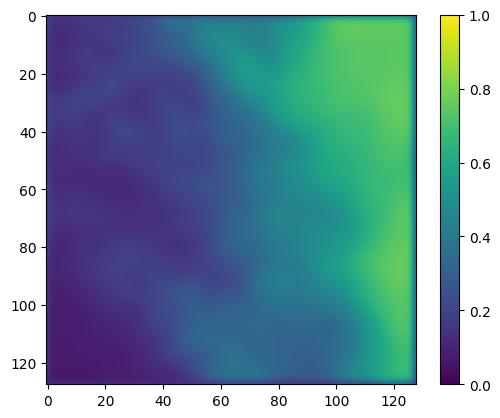

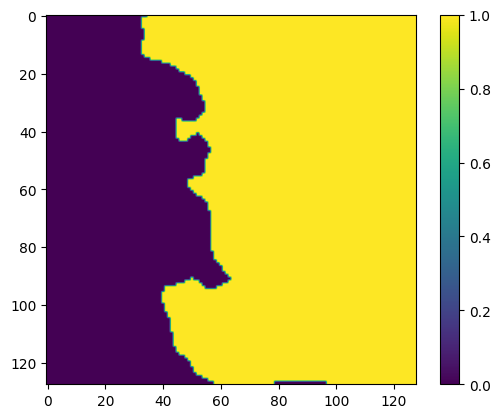

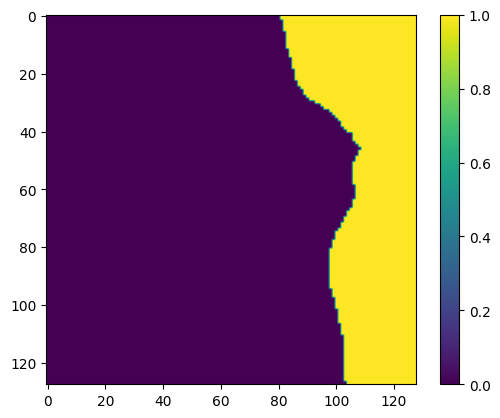

Epoch: 22 batch_nr: 2 Time: 2150.1298024000134 Time_diff: 10.008551399980206 loss: 1.7668707768122356
Epoch: 22 batch_nr: 10 Time: 2214.8404468999943 Time_diff: 5.283665800001472 loss: 2.1286826025355947
new val loss: 2.5419289271036782
Epoch: 23 batch_nr: 1 Time: 2239.193870100018 Time_diff: 8.18612770002801 loss: 3.0741606950759888
Epoch: 23 batch_nr: 9 Time: 2303.276825000008 Time_diff: 8.003119900007732 loss: 2.0780036807060243
new val loss: 2.5567239125569663
Epoch: 24 batch_nr: 0 Time: 2324.066029000038 Time_diff: 15.422804600035306 loss: 1.6757469177246094
Epoch: 24 batch_nr: 8 Time: 2389.436846000026 Time_diff: 8.089165000012144 loss: 1.689255992571513
new val loss: 2.6090739170710244
Epoch: 25 batch_nr: 7 Time: 2478.0046727000154 Time_diff: 8.083333800022956 loss: 1.6886481195688248
new val loss: 2.3568673133850098
Epoch: 26 batch_nr: 6 Time: 2564.502445799997 Time_diff: 7.948170499992557 loss: 1.7028105769838606
new val loss: 2.6594001849492392
Epoch: 27 batch_nr: 5 Time: 265

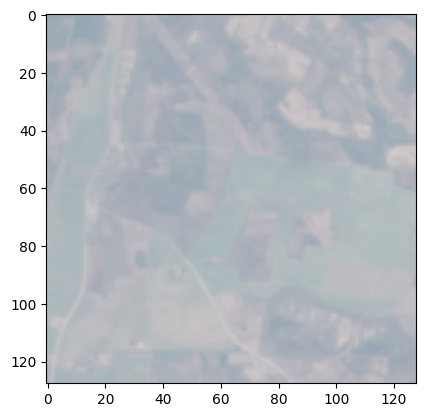

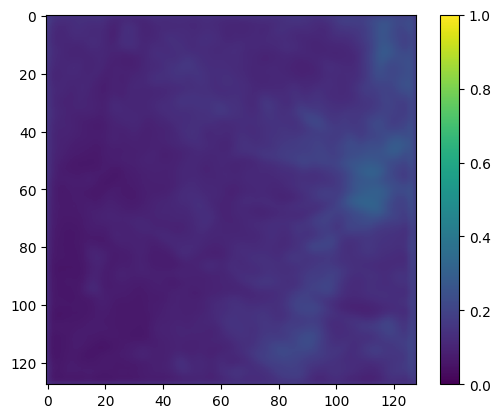

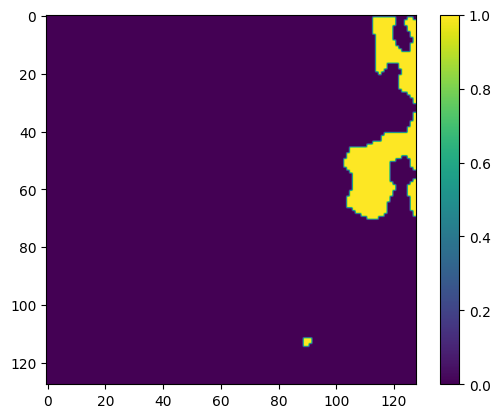

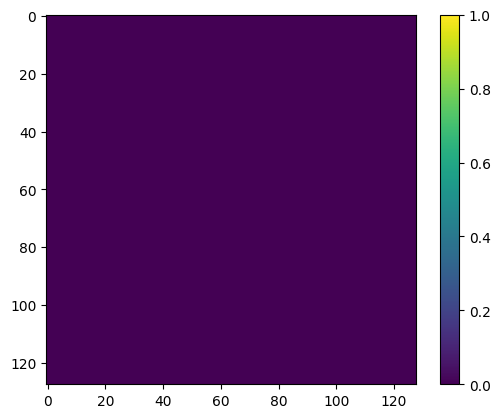

Epoch: 28 batch_nr: 4 Time: 2742.474050400022 Time_diff: 8.151495500002056 loss: 2.1943570613861083
new val loss: 2.325490673383077
Epoch: 29 batch_nr: 3 Time: 2829.657963500009 Time_diff: 7.934888200019486 loss: 1.7768971025943756
new val loss: 2.9884798924128213
Epoch: 30 batch_nr: 2 Time: 2916.052255699993 Time_diff: 8.00745229999302 loss: 1.420786738395691
Epoch: 30 batch_nr: 10 Time: 2981.79654890002 Time_diff: 5.074090600013733 loss: 1.9864908456802368
new val loss: 2.525352199872335
Epoch: 31 batch_nr: 1 Time: 3005.746934900002 Time_diff: 7.99738359998446 loss: 1.585882544517517
Epoch: 31 batch_nr: 9 Time: 3071.0139408000396 Time_diff: 8.43287220003549 loss: 1.9294179797172546
new val loss: 2.2822933197021484
Epoch: 32 batch_nr: 0 Time: 3091.9450417000335 Time_diff: 15.589691500004847 loss: 1.5518633127212524
Epoch: 32 batch_nr: 8 Time: 3156.8718134000083 Time_diff: 8.134221900021657 loss: 2.999009450276693
new val loss: 2.4789712031682334
Epoch: 33 batch_nr: 7 Time: 3243.356456

KeyboardInterrupt: 

In [9]:
import copy
from time import perf_counter
import random

epochs=500

def train_model(train_loader, val_loader, model, criterion, optimizer, scheduler):
    start_time = perf_counter()
    time = 0


    best_loss = float('inf')

    train_loss = []
    val_loss = []
    for epoch in range(epochs):
        avg_loss_list = []
        for batch_nr, (images,labels) in enumerate(train_loader):
            #Forward pass
            predictions = model(images.float())
            loss = criterion(predictions,labels.float())
            avg_loss_list.append(loss.item())
            
            if((batch_nr+epoch)%8==0):
                print("Epoch:",epoch,"batch_nr:",batch_nr,"Time:",perf_counter()-start_time,"Time_diff:",perf_counter()-start_time-time,"loss:",(sum(avg_loss_list)/len(avg_loss_list)))
            time=perf_counter()-start_time

            #Backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # Update learning rate
            scheduler.step()

        avg_v_loss_list = []
        for batch_nr, (images_valid,labels_valid) in enumerate(val_loader):
            predictions = model(images_valid.float())
            loss = criterion(predictions,labels_valid.float())
            avg_v_loss_list.append(loss.item())

        train_loss.append((sum(avg_loss_list)/len(avg_loss_list)))
        val_loss.append((sum(avg_v_loss_list)/len(avg_v_loss_list)))

        #Finds best model
        if (val_loss[-1]<best_loss):
            best_loss=val_loss[-1]
            best_model = copy.deepcopy(model)
            torch.save(model, 'best_UNET128h_model.pt')
            print("\n New best loss:",best_loss)

            
            plt.figure()
            plt.imshow(images_valid[0][:3].permute(1,2,0))
            plt.show()
            
            i=4

            predictions_softmax = nn.Softmax(dim=1)(predictions.detach())

            plt.figure()
            img=plt.imshow(predictions_softmax[0][i:i+1][:3].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()

            a = predictions_softmax.argmax (1)
            predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

            plt.figure()
            img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()


            plt.figure()
            img=plt.imshow(labels_valid[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
            plt.colorbar(img)
            plt.show()
        else:
            print("new val loss:",val_loss[-1])
    
    plt.plot(range(1,epochs+1),train_loss, color='r', label='losses')
    plt.plot(range(1,epochs+1),val_loss, color='g', label='losses_valid')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    return best_model

    

model = torch.load("best_UNET128h_model.pt")
optimizer = optim.Adam(model.parameters(),lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.9)
criterion = nn.CrossEntropyLoss(weight=torch.Tensor([627.9819277108434, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232, 7.415034213933109]))

best_model=train_model(training_loader,validation_loader,model,criterion,optimizer,scheduler)


In [3]:
def from_one_hot(label):
    return np.argmax(label,0,keepdims=True)

test_dataset = CloudDataset128h.CloudDataset("data\\train",transform=transform)
batch_size=1
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
test_it = iter(test_loader)
best_model = torch.load("best_UNET128h_model.pt")
criterion = nn.CrossEntropyLoss()
predictions = best_model(images)

NameError: name 'CloudDataset128c' is not defined

In [15]:
it = iter(test_loader)

In [12]:
images,labels = next(test_it)
predictions = best_model(images)

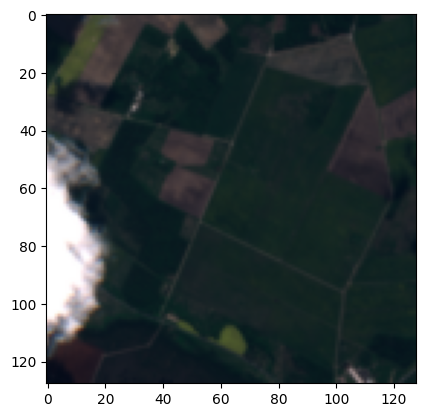

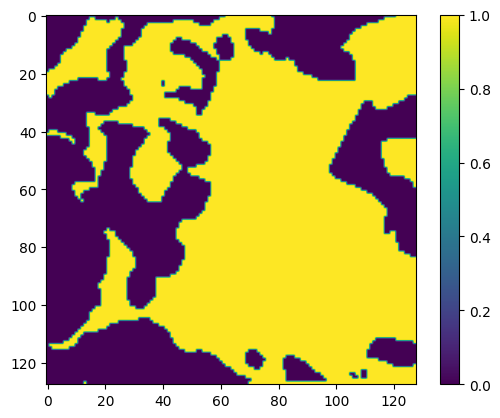

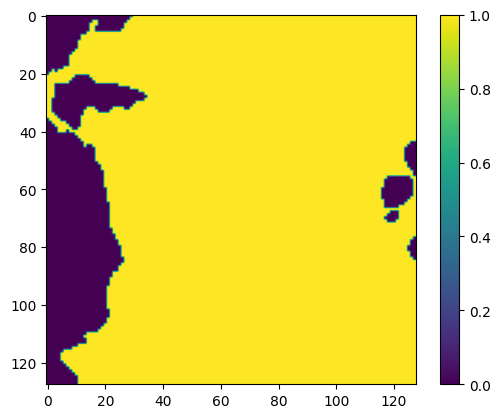

loss: tensor(1.2684, grad_fn=<DivBackward1>)


In [14]:

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()
i=1

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
plt.colorbar(img)
plt.show()

plt.figure()
img=plt.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

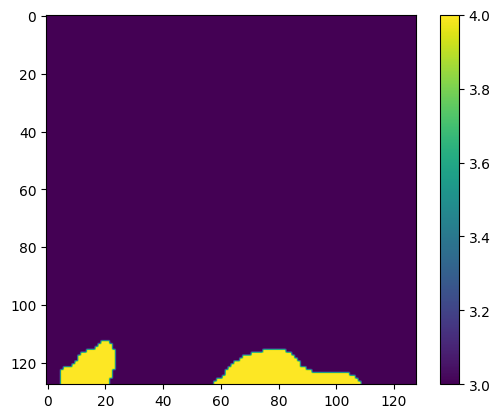

In [10]:


l = (from_one_hot(labels[0]))

plt.figure()
img=plt.imshow(l.permute(1,2,0))
plt.colorbar(img)
plt.show()

In [2]:
images,labels = next(test_it)
predictions = best_model(images)

NameError: name 'test_it' is not defined

In [1]:
images,labels = next(test_it)
predictions = best_model(images)

plt.figure()
plt.imshow(images[0][:3].permute(1,2,0))
plt.show()

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

plt.figure()
img=plt.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()


plt.figure()
img=plt.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.colorbar(img)
plt.show()

print("loss:",criterion(predictions,labels.float()))

NameError: name 'test_it' is not defined

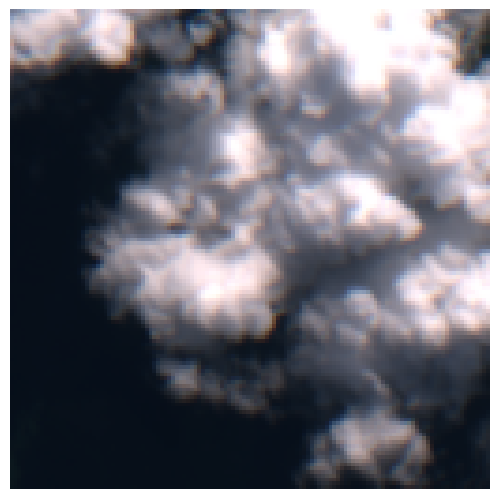

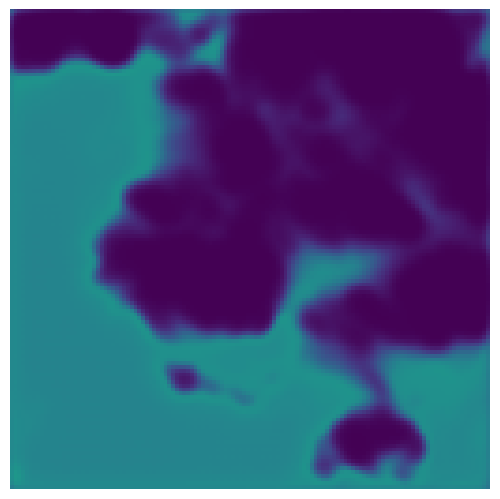

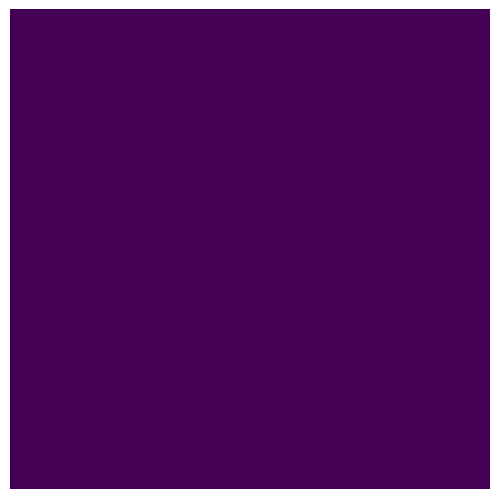

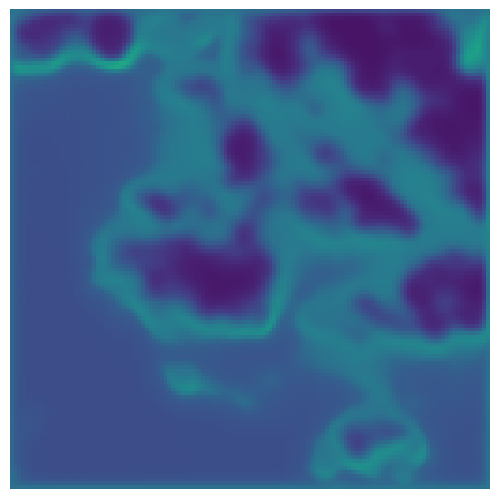

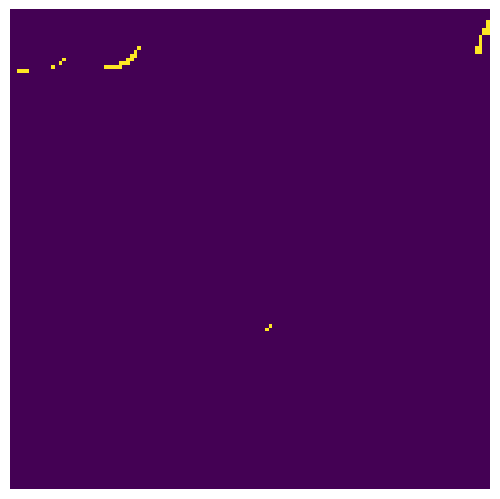

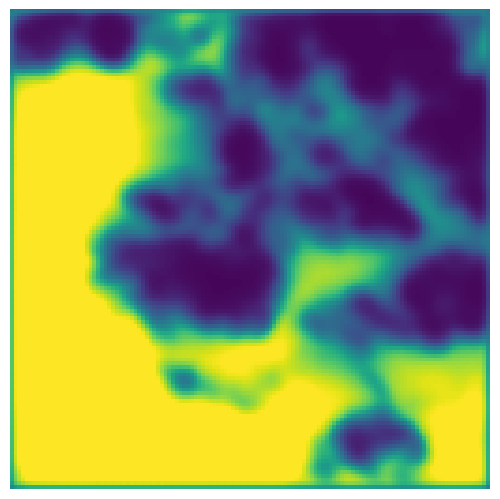

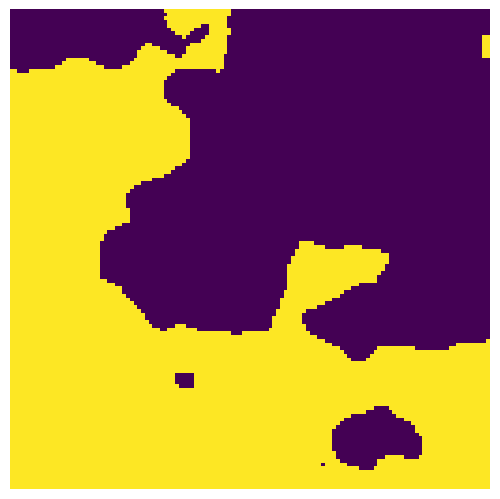

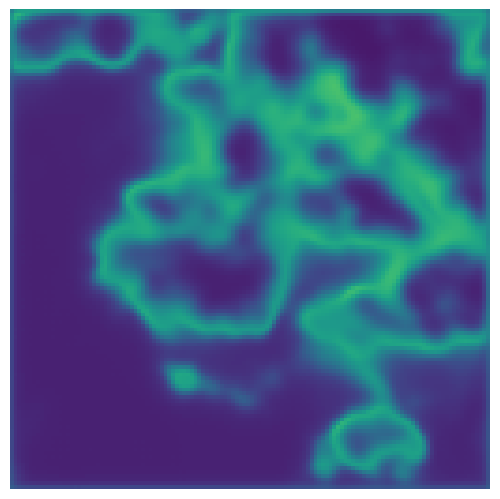

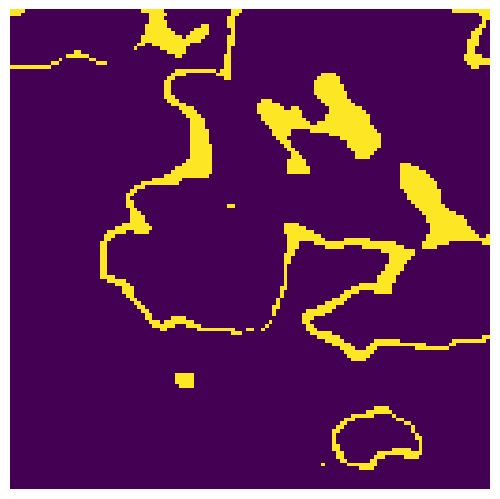

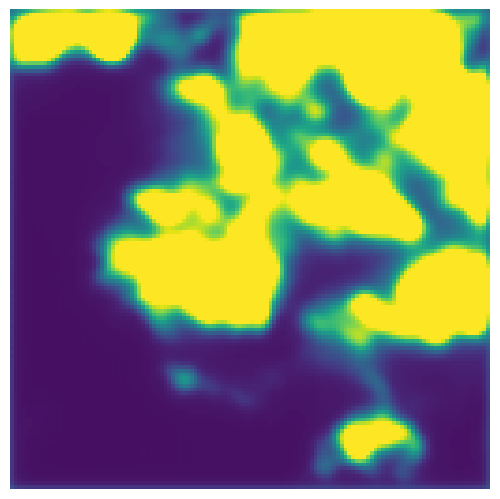

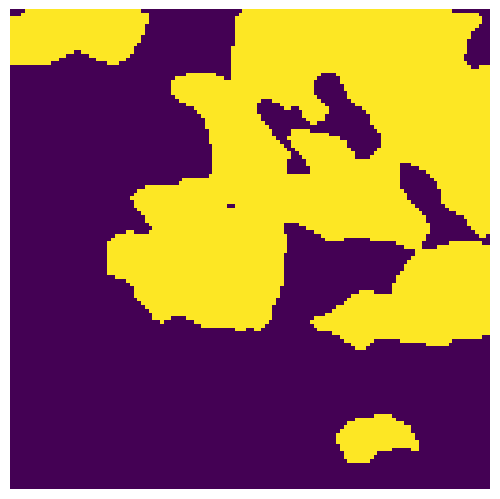

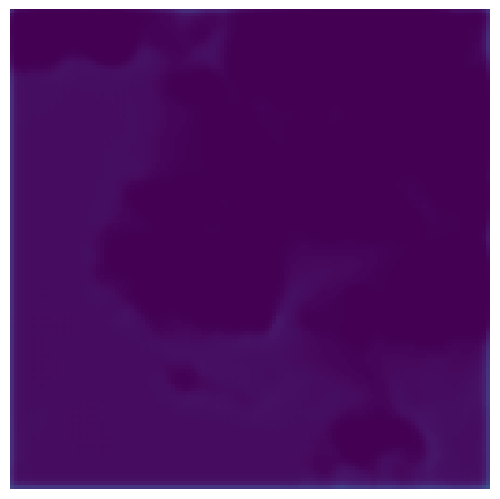

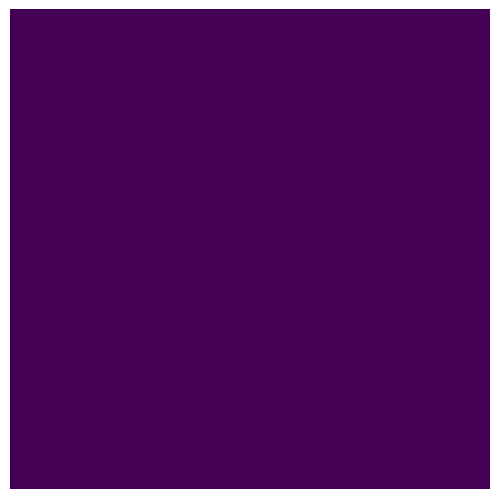

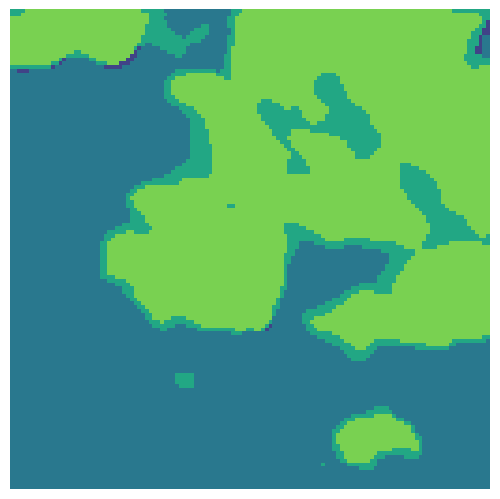

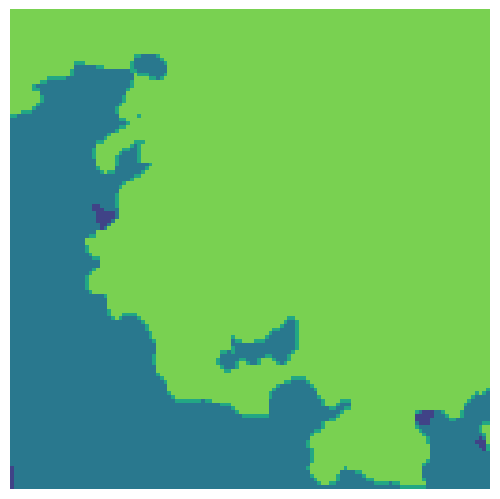

loss: tensor(1.0568, grad_fn=<DivBackward1>)


In [50]:
#For creating images

predictions = best_model(images)

predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
a = predictions_softmax.argmax (1)
predictions_binary = torch.zeros (predictions_softmax.shape).scatter (1, a.unsqueeze (1), 1.0)

fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(images[0][:3].permute(1,2,0))
plt.savefig('img.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

for i in range(6):

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_softmax[0][i:i+1].permute(1,2,0),vmin=0, vmax=0.5)
    plt.savefig('softmax'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()

    fig = plt.figure(frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(predictions_binary[0][i:i+1].permute(1,2,0),vmin=0, vmax=1)
    plt.savefig('binary'+str(i)+'.jpg', bbox_inches='tight',pad_inches=0)
    plt.show()



fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(predictions_binary[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('predictions.jpg', bbox_inches='tight',pad_inches=0)
plt.show()


fig = plt.figure(frameon=False)
ax = plt.Axes(fig, [0., 0., 1., 1.])
ax.set_axis_off()
fig.add_axes(ax)
ax.imshow(from_one_hot(labels[0]).permute(1,2,0),vmin=0, vmax=5)
plt.savefig('label.jpg', bbox_inches='tight',pad_inches=0)
plt.show()

print("loss:",criterion(predictions,labels.float()))


In [63]:
_,labels = next(iter(training_loader))

In [81]:

vs = [0,0,0,0,0,0]
total=0
for batch_nr, (_,labels) in enumerate(training_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
for batch_nr, (_,labels) in enumerate(validation_loader):
    for label in labels:
        i=0
        while i<6:
            sum = torch.sum(label[i:i+1]).item()
            vs[i]+=sum
            total+=sum
            i+=1
print(vs)
m = max(vs)
for i, e in enumerate(vs):
    vs[i]=m/e
print(vs)

[830, 521225, 199987, 339080, 326761, 70293]
[627.9819277108434, 1.0, 2.606294409136594, 1.537174118202194, 1.5951261013401232, 7.415034213933109]


In [11]:
#Evaluate
total = 0
correct = 0

for batch_nr, (images, labels) in enumerate(test_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        y = torch.sum((pred==label))
        correct += y
        total += 128*128
        i+=1

print("Accuracy =", correct/total)

    

Accuracy = tensor(0.5783)


In [13]:
# IoU calculation

Union = [0,0,0,0,0,0] 
Intersection = [0,0,0,0,0,0]

for batch_nr, (images, labels) in enumerate(test_loader):

    predictions = best_model(images)

    predictions_softmax = nn.Softmax(dim=1)(predictions.detach())
    predictions_binary = torch.zeros(predictions_softmax.shape).scatter (1, predictions_softmax.argmax(1).unsqueeze(1), 1.0)

    i=0
    while i<len(predictions):
        pred = from_one_hot(predictions_binary[i])
        label = from_one_hot(labels[i])

        for p_class in range(6):
            inter=torch.sum((pred==label)*(label==p_class))
            uni = (torch.sum((label==p_class)) + torch.sum((label==p_class)) - inter)
            Intersection[p_class] += inter.item()
            Union[p_class] += uni.item()
        i+=1

for p_class in range(6):
    try:
        print("IoU, class=",p_class,":",Intersection[p_class]/Union[p_class])
    except:
        print("IoU, class=",p_class,":","NAN (Union=0)")

IoU, class= 0 : 0.0
IoU, class= 1 : 0.47990792787202263
IoU, class= 2 : 0.37283947435397663
IoU, class= 3 : 0.13801988257715372
IoU, class= 4 : 0.618909068943299
IoU, class= 5 : 0.9694409703376832


In [6]:
from torchsummary import summary
best_model = torch.load("best_UNET128c_model.pt")
summary(best_model)


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            6,976
├─Conv2d: 1-2                            36,928
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            295,168
├─Conv2d: 1-8                            590,080
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           1,180,160
├─Conv2d: 1-11                           2,359,808
├─MaxPool2d: 1-12                        --
├─Conv2d: 1-13                           4,719,616
├─Conv2d: 1-14                           9,438,208
├─MaxPool2d: 1-15                        --
├─Conv2d: 1-16                           18,876,416
├─Conv2d: 1-17                           37,750,784
├─ConvTranspose2d: 1-18                  8,389,632
├─Conv2d: 1-19                           18,875,392
├─Conv2d: 1-20                

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            6,976
├─Conv2d: 1-2                            36,928
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            73,856
├─Conv2d: 1-5                            147,584
├─MaxPool2d: 1-6                         --
├─Conv2d: 1-7                            295,168
├─Conv2d: 1-8                            590,080
├─MaxPool2d: 1-9                         --
├─Conv2d: 1-10                           1,180,160
├─Conv2d: 1-11                           2,359,808
├─MaxPool2d: 1-12                        --
├─Conv2d: 1-13                           4,719,616
├─Conv2d: 1-14                           9,438,208
├─MaxPool2d: 1-15                        --
├─Conv2d: 1-16                           18,876,416
├─Conv2d: 1-17                           37,750,784
├─ConvTranspose2d: 1-18                  8,389,632
├─Conv2d: 1-19                           18,875,392
├─Conv2d: 1-20                